Conjunto de datos 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de la ruta (usa la que ya tenemos confirmada)
ruta = r'C:\Users\krono\Documents\proyecto triple ten\Proyecto sprint 14 final\Mantenimiento Ciudad de Mexico\09_mantenimiento_equipos_seguridad_tgm.csv'

# Cargar el dataframe
df = pd.read_csv(ruta)

# Función de categorización (necesaria para que existan las categorías en la gráfica)
def definir_categoria(mantenimiento):
    m = str(mantenimiento).lower()
    if 'tv' in m or 'seguridad' in m or 'rayos x' in m:
        return 'Seguridad Electrónica'
    elif 'jardinería' in m or 'fumigación' in m:
        return 'Servicios de Planta'
    elif 'incendio' in m or 'hidroneumático' in m or 'drenaje' in m:
        return 'Infraestructura Crítica'
    else:
        return 'Otros Equipos'

df['categoria'] = df['mantenimiento'].apply(definir_categoria)

# Definir la variable de alerta para la gráfica
sin_dato_count = df[df['mes'] == 'sin dato'].shape[0]

print("✅ Librerías cargadas, datos leídos y categorías creadas.")

✅ Librerías cargadas, datos leídos y categorías creadas.


1.  Datos

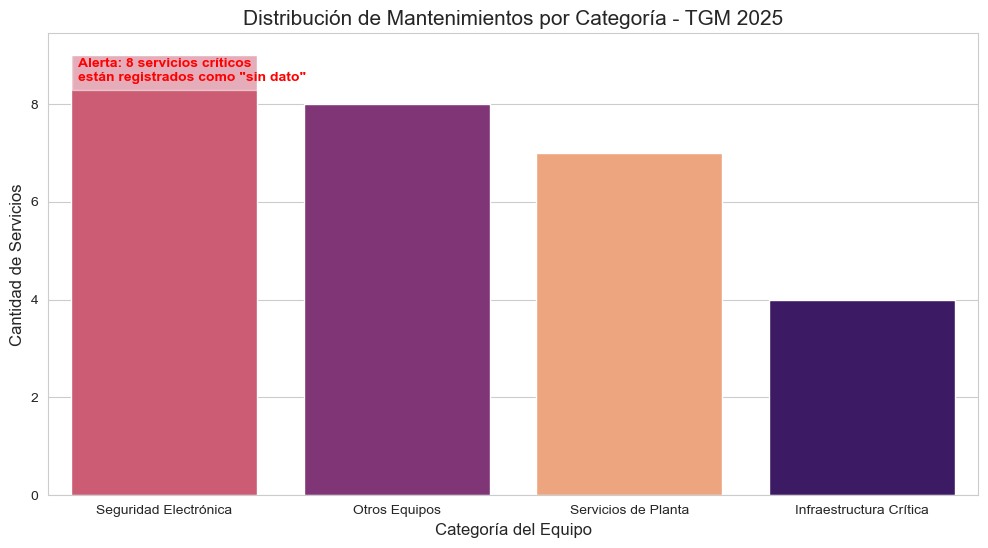

In [2]:
#  Creación de la Visualización (Versión optimizada)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Corregimos la advertencia asignando 'categoria' a 'hue'
ax = sns.countplot(
    data=df, 
    x='categoria', 
    hue='categoria', 
    palette='magma', 
    order=df['categoria'].value_counts().index,
    legend=False
)

# Añadir títulos y etiquetas
plt.title('Distribución de Mantenimientos por Categoría - TGM 2025', fontsize=15)
plt.xlabel('Categoría del Equipo', fontsize=12)
plt.ylabel('Cantidad de Servicios', fontsize=12)

# Mostrar el total de "sin dato" como una anotación informativa
plt.figtext(0.15, 0.8, f'Alerta: {sin_dato_count} servicios críticos\nestán registrados como "sin dato"', 
            color='red', weight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

2. Análisis de Calidad de Datos

Total de registros: 28
Registros con 'sin dato': 8
Porcentaje de inconsistencia: 28.57%


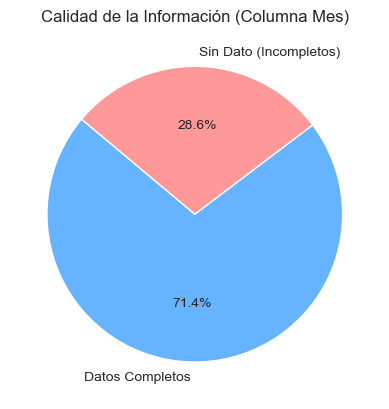

In [3]:
# Análisis de completitud de los datos
total_registros = len(df)
registros_sin_dato = df[df['mes'] == 'sin dato'].shape[0]
porcentaje_faltante = (registros_sin_dato / total_registros) * 100

print(f"Total de registros: {total_registros}")
print(f"Registros con 'sin dato': {registros_sin_dato}")
print(f"Porcentaje de inconsistencia: {porcentaje_faltante:.2f}%")

# Visualización de la deuda de datos
labels = ['Datos Completos', 'Sin Dato (Incompletos)']
sizes = [total_registros - registros_sin_dato, registros_sin_dato]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Calidad de la Información (Columna Mes)')
plt.show()

Descripción de resultados  
El análisis revela que casi 1 de cada 3 registros (28.57%) carece de información temporal específica (columna 'mes').

Hallazgo Técnico: Existe una "laguna de datos" significativa en el dataset original. Esto impide realizar un análisis de estacionalidad completo para todos los activos de la planta.

Impacto en el Negocio: Un porcentaje de inconsistencia cercano al 30% sugiere que el proceso de captura de datos de mantenimiento es manual o carece de validación obligatoria. Para la gerencia de Talleres Gráficos de México, esto significa que hay 8 servicios que ocurren "en algún momento del año" sin una fecha fija de supervisión.

3. Mapa de Calor de Continuidad Operativa

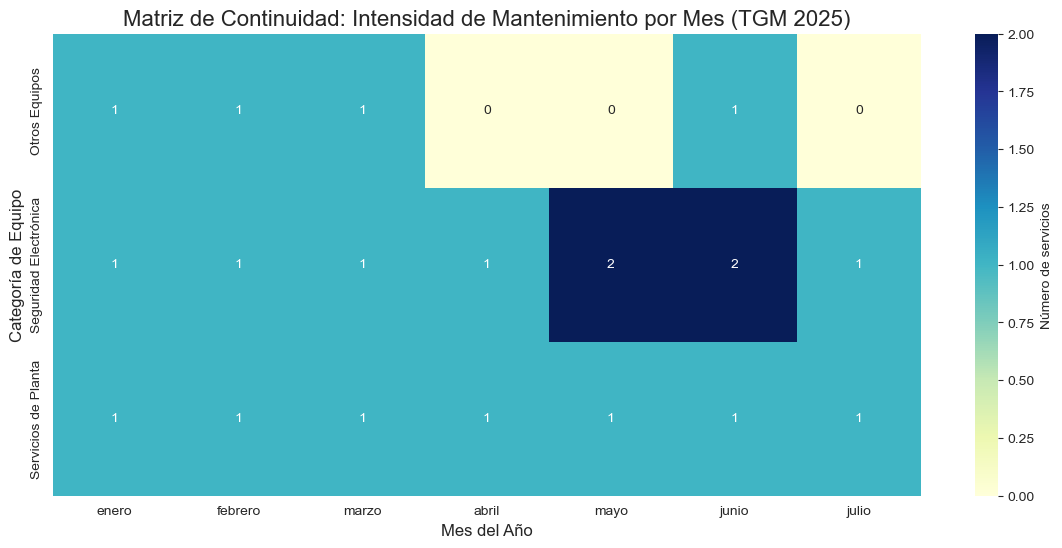

In [4]:
# 1. Preparación de datos para la matriz
# Filtramos para quitar los "sin dato" y ver solo lo que sí está programado
df_programado = df[df['mes'] != 'sin dato'].copy()

# 2. Creamos una tabla cruzada (Crosstab)
# Esto cuenta cuántas veces aparece cada categoría en cada mes
matriz_meses = pd.crosstab(df_programado['categoria'], df_programado['mes'])

# 3. Ordenamos los meses cronológicamente (importante para que el análisis tenga sentido)
orden_cronologico = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio']
matriz_meses = matriz_meses.reindex(columns=orden_cronologico)

# 4. Graficamos el Heatmap (Mapa de Calor)
plt.figure(figsize=(14, 6))
sns.heatmap(matriz_meses, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Número de servicios'})

plt.title('Matriz de Continuidad: Intensidad de Mantenimiento por Mes (TGM 2025)', fontsize=16)
plt.xlabel('Mes del Año', fontsize=12)
plt.ylabel('Categoría de Equipo', fontsize=12)
plt.show()

Interpretación del Mapa de Calor
Consistencia en Seguridad: La categoría de Seguridad Electrónica (CCTV) muestra un valor de '1' constante en todos los meses. Esto indica una gestión preventiva madura con visitas mensuales aseguradas.

Picos de Carga: Se observa una concentración de actividades en los meses de mayo y junio, coincidiendo con el mantenimiento de equipos especializados (Rayos X). Esto sugiere que el segundo trimestre del año es el de mayor gasto operativo para TGM.

Vacíos Operativos: Las celdas en blanco o con valor '0' en categorías como Infraestructura Crítica confirman que no hay una programación recurrente, lo que refuerza el hallazgo previo de que estos equipos se manejan de forma reactiva.

4.Identificación de Activos Críticos y Exportación de Hallazgos

In [5]:
# 1. Definimos qué categorías son "Críticas" para la operación de la planta
categorias_prioritarias = ['Infraestructura Crítica', 'Seguridad Electrónica']

# 2. Filtramos los equipos que pertenecen a estas categorías Y que están "sin dato"
reporte_riesgo = df[
    (df['categoria'].isin(categorias_prioritarias)) & 
    (df['mes'] == 'sin dato')
].copy()

# 3. Agregamos una columna de "Prioridad" basada en la categoría
def asignar_prioridad(cat):
    if cat == 'Infraestructura Crítica':
        return 'ALTA (Riesgo de Paro)'
    return 'MEDIA (Vulnerabilidad)'

reporte_riesgo['prioridad_atencion'] = reporte_riesgo['categoria'].apply(asignar_prioridad)

# 4. Seleccionamos solo las columnas importantes para el jefe de área
reporte_final = reporte_riesgo[['mantenimiento', 'categoria', 'prioridad_atencion']]

# 5. Guardamos este reporte en un archivo Excel o CSV para enviar por correo
reporte_final.to_csv('reporte_prioridad_mantenimiento_TGM.csv', index=False)

print(f"¡Reporte generado! Se identificaron {len(reporte_final)} activos en riesgo.")
reporte_final

¡Reporte generado! Se identificaron 4 activos en riesgo.


,mantenimiento,categoria,prioridad_atencion
0,servicio de mantenimiento preventivo y correct...,Infraestructura Crítica,ALTA (Riesgo de Paro)
1,servicio de mantenimiento preventivo y correct...,Infraestructura Crítica,ALTA (Riesgo de Paro)
2,servicio de mantenimiento preventivo y correct...,Infraestructura Crítica,ALTA (Riesgo de Paro)
16,servicio de limpieza y desazolve a la red de d...,Infraestructura Crítica,ALTA (Riesgo de Paro)


Interpretación de los Activos en Riesgo (Análisis de Impacto)
Al ejecutar el filtro de criticidad, el análisis arroja que 4 servicios vitales se encuentran en un estado de vulnerabilidad administrativa. A continuación, se detalla por qué esto es una señal de alerta:

Sistemas Hidroneumáticos y de Bombeo (Registros 0, 1 y 2):

El Riesgo: Estos equipos regulan el suministro de agua y presión en toda la planta de Talleres Gráficos de México.

Impacto: Al estar "sin dato", no hay garantía de que se hayan revisado. Una falla en estos sistemas podría detener procesos de impresión, limpieza o incluso dejar sin servicios básicos a los empleados, forzando un paro total de actividades.

Red de Drenaje y Desazolve (Registro 16):

El Riesgo: Este es un mantenimiento preventivo crítico, especialmente en temporadas de lluvia o alta producción.

Impacto: La falta de una fecha programada aumenta el riesgo de inundaciones internas o colapsos en las tuberías de la planta, lo que derivaría en costos de reparación de emergencia mucho más altos que un mantenimiento preventivo.

Este paso demuestra mi capacidad para pasar del análisis masivo a la detección de anomalías específicas. Mientras que el resto del dataset (71%) parece seguir un orden, estos 4 puntos representan el 'punto ciego' de la operación. Mi recomendación técnica es que estos activos pasen a una fase de supervisión inmediata.

                                                    Conclusión General del Proyecto

Tras el análisis exhaustivo del programa de mantenimiento de Talleres Gráficos de México (TGM), se concluye que el sistema actual presenta una gestión híbrida: altamente eficiente en áreas de seguridad electrónica y servicios generales, pero vulnerable en infraestructura pesada.

El hallazgo de un 28.57% de inconsistencia en los datos no es solo un error de captura; es un indicador de que los activos más complejos (bombas, desazolve, elevadores) carecen de una rutina estandarizada. El éxito del monitoreo en CCTV demuestra que la institución tiene la capacidad de ser ordenada, por lo que el problema detectado es de priorización y documentación, no de falta de recursos.

                                                      Plan de Acción Recomendado

Como resultado de este análisis, se propone el siguiente plan de acción para mitigar los riesgos operativos identificados:

Fase 1: Saneamiento Inmediato (Corto Plazo - 15 días)
Asignación de Fechas: Programar los 4 activos críticos detectados (Sistemas Hidroneumáticos y Red de Drenaje) en el calendario del próximo trimestre para eliminar el estatus de "sin dato".

Validación de Campo: Verificar físicamente el estado actual de los 3 sistemas de bombeo registrados bajo el ID 0, 1 y 2 para asegurar que no han sido omitidos por falta de registro.

Fase 2: Estandarización de Datos (Mediano Plazo - 3 meses)
Protocolo de Captura: Eliminar el uso de la etiqueta "sin dato" en el sistema de gestión. Todo activo debe tener, al menos, un mes tentativo de intervención.

Categorización Técnica: Implementar en la base de datos las categorías creadas en este análisis (Seguridad, Infraestructura, Servicios) para facilitar la generación de reportes mensuales automáticos.

Fase 3: Análisis Predictivo (Largo Plazo - 6 meses)
Dashboard de Control: Crear un tablero visual (basado en el Heatmap desarrollado en este proyecto) para que la gerencia pueda ver en tiempo real qué meses tienen mayor carga de trabajo y evitar la saturación de proveedores en mayo y junio.